In [ ]:

!pip install -q facenet-pytorch==2.5.3 decord==0.6.0 scikit-learn==1.5.2 tqdm==4.65.0 pillow fer
!pip install -q transformers==4.43.3


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 47.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.0.0 requires tqdm>=4.66.3, but you have tqdm 4.65.0 which is incompatible.
dataproc-spark-connect 0.8.3 requires tqdm>=4.67, but you have tqdm 4.65.0 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━

In [ ]:
import os, shutil, math, time
import numpy as np, pandas as pd
from PIL import Image
from tqdm import tqdm
import torch
from decord import VideoReader, cpu
from facenet_pytorch import MTCNN, InceptionResnetV1
from sklearn.cluster import DBSCAN
from fer import FER
from IPython.display import HTML, display

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# Face detector + embedder (FaceNet)
mtcnn = MTCNN(keep_all=True, device=device)
face_encoder = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# Emotion detector (FER)
emotion_detector = FER(mtcnn=True)  # uses mtcnn internally for alignment (fast enough)

# Try to load VideoMAE; if unavailable, we'll fall back to XCLIP
use_videomae = True
try:
    from transformers import VideoMAEFeatureExtractor, VideoMAEForVideoClassification
    vm_feature_extractor = VideoMAEFeatureExtractor.from_pretrained("MCG-NJU/videomae-base-finetuned-kinetics")
    vm_model = VideoMAEForVideoClassification.from_pretrained("MCG-NJU/videomae-base-finetuned-kinetics").to(device)
    print("Loaded VideoMAE (action model).")
except Exception as e:
    print("VideoMAE load failed — will fall back to XCLIP. Error:", e)
    use_videomae = False
    from transformers import XCLIPProcessor, XCLIPModel
    xclip_processor = XCLIPProcessor.from_pretrained("microsoft/xclip-base-patch32")
    xclip_model = XCLIPModel.from_pretrained("microsoft/xclip-base-patch32").to(device)
    print("Loaded XCLIP fallback.")


/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: SyntaxWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:367: SyntaxWarning: invalid escape sequence '\d'
  rotation_lines = [l for l in lines if 'rotate          :' in l and re.search('\d+$', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:370: SyntaxWarning: invalid escape sequence '\d'
  match = re.search('\d+$', rotation_line)
  if event.key is 'enter':



Device: cuda


  0%|          | 0.00/107M [00:00<?, ?B/s]

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

  warnings.warn(



config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Loaded VideoMAE (action model).


In [ ]:
from google.colab import files
uploaded = files.upload()     # click and pick 3 or more .mp4 files
video_files = list(uploaded.keys())
print("Uploaded:", video_files)


Saving videoplayback (2).mp4 to videoplayback (2).mp4
Saving videoplayback (1).mp4 to videoplayback (1).mp4
Saving videoplayback.mp4 to videoplayback.mp4
Uploaded: ['videoplayback (2).mp4', 'videoplayback (1).mp4', 'videoplayback.mp4']


In [ ]:
os.makedirs("faces_raw", exist_ok=True)
os.makedirs("person_galleries", exist_ok=True)

def sample_chunk_frames(video_path, start_frame, end_frame, n_frames=16):
    vr = VideoReader(video_path, ctx=cpu(0))
    if end_frame <= start_frame: return []
    indices = np.linspace(start_frame, end_frame-1, num=min(n_frames, max(1,end_frame-start_frame)), dtype=int)
    frames = [vr[i].asnumpy() for i in indices]
    return frames

def detect_faces_in_frame(frame_rgb):
    # frame_rgb: numpy RGB
    pil = Image.fromarray(frame_rgb)
    boxes, probs = mtcnn.detect(pil)
    if boxes is None:
        return []
    faces = []
    for i, box in enumerate(boxes):
        x1,y1,x2,y2 = [int(v) for v in box]
        h,w,_ = frame_rgb.shape
        x1,y1 = max(0,x1), max(0,y1)
        x2,y2 = min(w,x2), min(h,y2)
        if x2<=x1 or y2<=y1: continue
        crop = frame_rgb[y1:y2, x1:x2]
        faces.append((crop, (x1,y1,x2,y2), float(probs[i]) if probs is not None else 1.0))
    return faces

def embed_face(crop_np):
    # crop_np: RGB numpy
    img = Image.fromarray(crop_np).resize((160,160))
    t = torch.tensor(np.array(img)).permute(2,0,1).unsqueeze(0).float().to(device) / 255.0
    with torch.no_grad():
        emb = face_encoder(t).cpu().numpy().flatten()
    return emb

def detect_emotion_for_crop(crop_np):
    # FER expects BGR or PIL; pass RGB numpy
    try:
        res = emotion_detector.detect_emotions(crop_np)  # returns list of dicts for faces; but when passing a crop likely one
        if isinstance(res, list) and len(res)>0:
            # res[0]['emotions'] is dict of scores
            em = res[0].get('emotions', {})
            # choose max
            if em:
                return max(em.items(), key=lambda x:x[1])[0], max(em.values())
    except Exception:
        pass
    return "unknown", 0.0


In [ ]:
# Parameters — you can tune these
CHUNK_SECONDS = 5       # length of each chunk for action recognition
SAMPLE_RATE_FPS = 2     # how many frames per second to sample for face detection (approx)
FRAMES_PER_CHUNK_FOR_ACTION = 16  # number of frames VideoMAE/XCLIP will take per chunk

all_face_records = []   # each: dict with video, frame, timestamp, crop_path, embedding, emotion, bbox
all_chunks = []         # each: dict with video, chunk_start_frame, chunk_end_frame, timestamp

for vid in video_files:
    path = vid
    vr = VideoReader(path, ctx=cpu(0))
    fps = int(vr.get_avg_fps())
    total_frames = len(vr)
    chunk_frames = CHUNK_SECONDS * fps
    print(f"Processing {vid}: {total_frames} frames @ {fps} fps, chunk {CHUNK_SECONDS}s => {chunk_frames} frames per chunk")

    for chunk_start in range(0, total_frames, chunk_frames):
        chunk_end = min(total_frames, chunk_start + chunk_frames)
        timestamp = round(chunk_start / fps, 2)
        all_chunks.append({"video": vid, "start": chunk_start, "end": chunk_end, "timestamp": timestamp})

        # sample frames inside chunk for face detection (approx SAMPLE_RATE_FPS)
        step = max(1, int(fps / SAMPLE_RATE_FPS))
        for fidx in range(chunk_start, chunk_end, step):
            frame = vr[fidx].asnumpy()
            faces = detect_faces_in_frame(frame)
            for j, (crop, bbox, conf) in enumerate(faces):
                emb = embed_face(crop)
                em_label, em_score = detect_emotion_for_crop(crop)
                fname = f"{vid}_f{fidx}_face{j}.jpg"
                fpath = os.path.join("faces_raw", fname)
                Image.fromarray(crop).save(fpath)
                all_face_records.append({
                    "video": vid,
                    "frame": int(fidx),
                    "timestamp": round(fidx/fps,2),
                    "crop_path": fpath,
                    "embedding": emb,
                    "emotion": em_label,
                    "emotion_score": em_score,
                    "bbox": bbox,
                    "det_conf": conf
                })

print("Total detected face crops:", len(all_face_records))
faces_df = pd.DataFrame(all_face_records)


Processing videoplayback (2).mp4: 774 frames @ 23 fps, chunk 5s => 115 frames per chunk


Expected: ['input_1']
Received: inputs=Tensor(shape=(1, 64, 64))
  warnings.warn(msg)



Processing videoplayback (1).mp4: 4042 frames @ 29 fps, chunk 5s => 145 frames per chunk
Processing videoplayback.mp4: 3583 frames @ 29 fps, chunk 5s => 145 frames per chunk
Total detected face crops: 279


In [ ]:
 # =========================================================
# 📦 Install + Imports
# =========================================================
!pip install facenet-pytorch --quiet

import torch
from facenet_pytorch import InceptionResnetV1
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import cv2

# =========================================================
# ⚙️ Load FaceNet (PyTorch version)
# =========================================================
device = 'cuda' if torch.cuda.is_available() else 'cpu'
facenet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# =========================================================
# 🧠 Function: Generate face embedding
# =========================================================
def get_embedding(model, face):
    # Resize and normalize
    face = cv2.resize(face, (160, 160))
    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    face = torch.tensor(face / 255.0, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model(face)
    return embedding.cpu().numpy().flatten()

# =========================================================
# 🩵 Fix missing key name ('crop_path' -> 'face_path')
# =========================================================
for r in all_face_records:
    if "crop_path" in r and "face_path" not in r:
        r["face_path"] = r["crop_path"]

# =========================================================
# 🧩 Extract embeddings for all detected faces
# =========================================================
embeddings = []
valid_records = []

for record in tqdm(all_face_records, desc="Extracting face embeddings"):
    try:
        face = cv2.imread(record["face_path"])
        if face is not None:
            emb = get_embedding(facenet, face)
            embeddings.append(emb)
            valid_records.append(record)
    except Exception as e:
        print(f"⚠️ Skipped one face due to error: {e}")

embeddings = np.array(embeddings)

# =========================================================
# 🤝 Cluster similar faces (identify unique persons)
# =========================================================
cluster = AgglomerativeClustering(
    n_clusters=None,
    metric="euclidean",
    linkage="ward",
    distance_threshold=1.0
)
labels = cluster.fit_predict(embeddings)

num_persons = len(set(labels))
print(f"\n✅ Total unique persons detected: {num_persons}")

# Assign Person IDs back to records
for i, record in enumerate(valid_records):
    record["person_id"] = int(labels[i])

print("✅ Face embeddings extracted and clustered successfully!")


Extracting face embeddings: 100%|██████████| 279/279 [00:04<00:00, 61.41it/s]



✅ Total unique persons detected: 66
✅ Face embeddings extracted and clustered successfully!


Total faces: 279, Unique persons: 66

🧍 Person 0 — 4 appearances


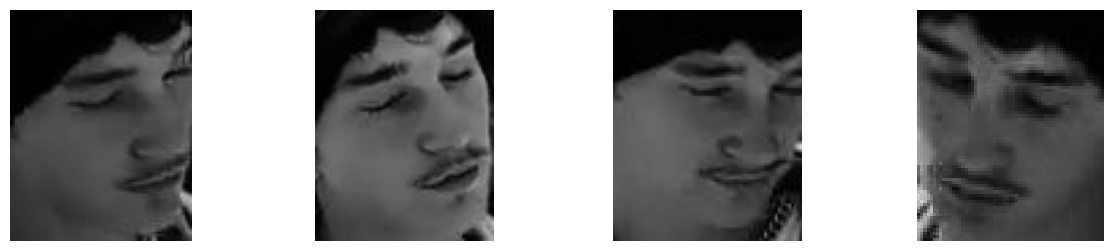


🧍 Person 1 — 4 appearances


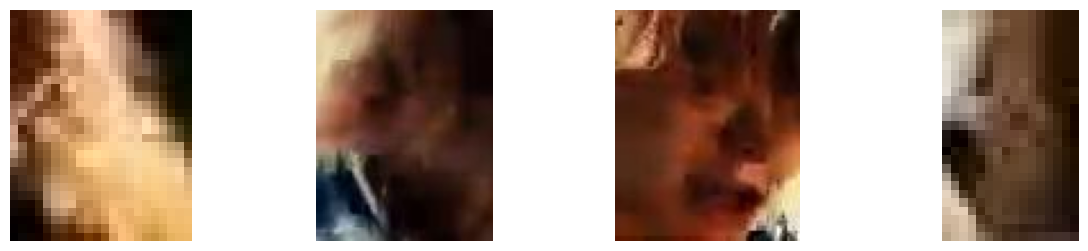


🧍 Person 2 — 14 appearances


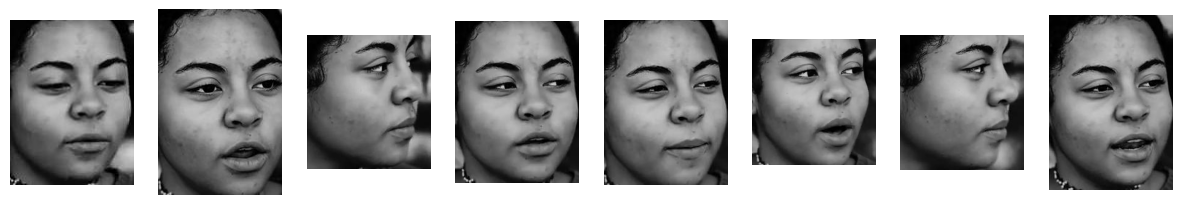


🧍 Person 3 — 10 appearances


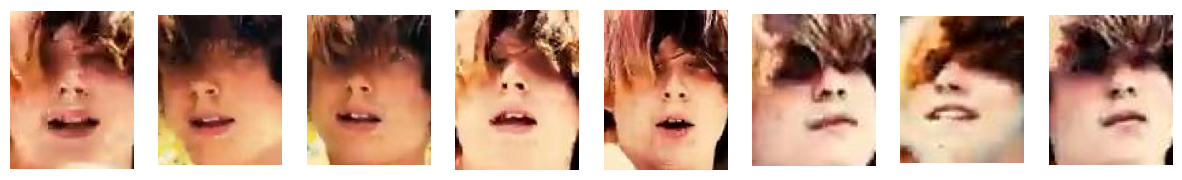


🧍 Person 4 — 3 appearances


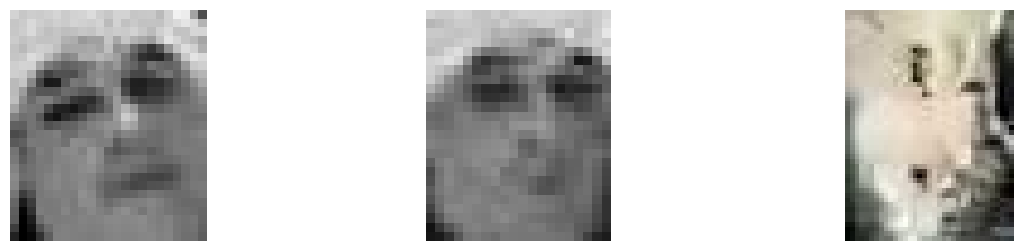


🧍 Person 5 — 8 appearances


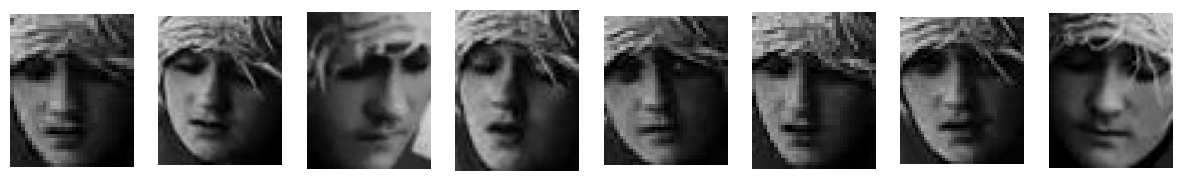


🧍 Person 6 — 3 appearances


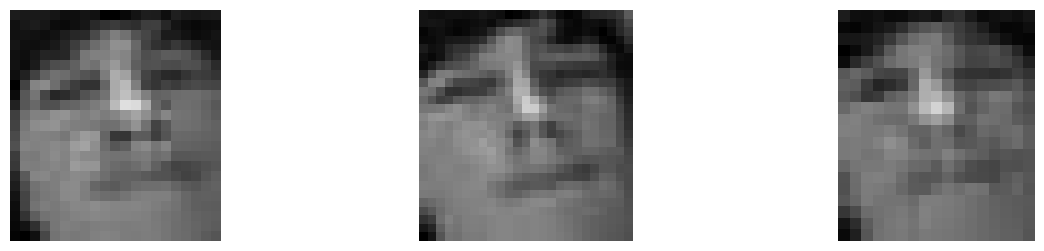


🧍 Person 7 — 4 appearances


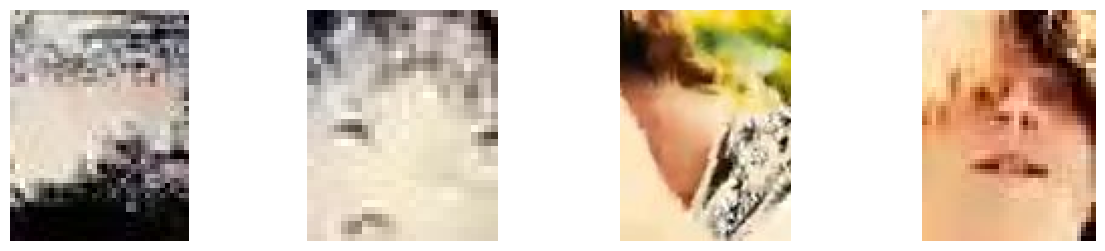


🧍 Person 8 — 4 appearances


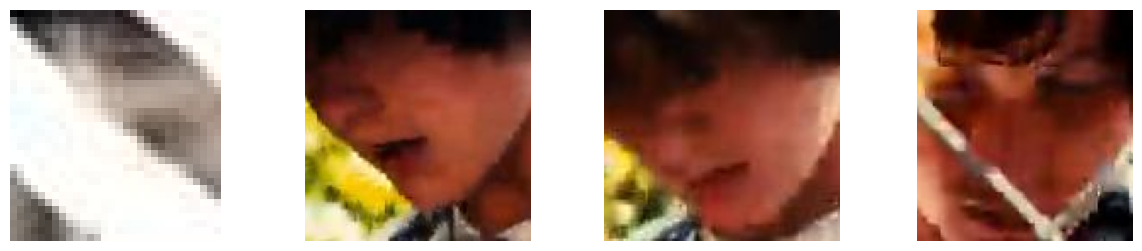


🧍 Person 9 — 4 appearances


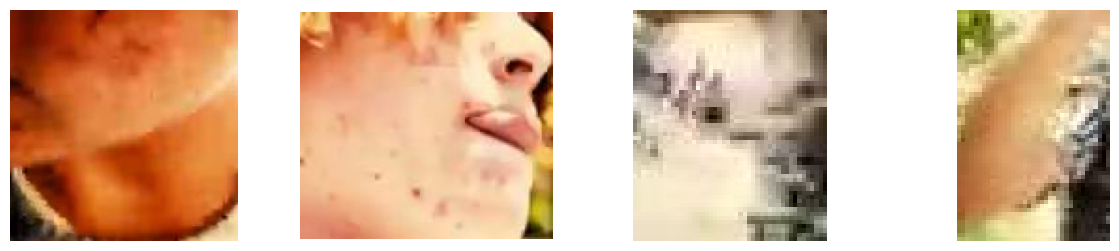


✅ Visualization complete. Showing top 10 detected persons.


In [ ]:
import math
from IPython.display import Image, display
import pandas as pd

# =========================================================
# 📁 Create a DataFrame for clarity
# =========================================================
df = pd.DataFrame(valid_records)
print(f"Total faces: {len(df)}, Unique persons: {df['person_id'].nunique()}")

# =========================================================
# 🧩 Group by person_id
# =========================================================
grouped = df.groupby("person_id")

# =========================================================
# 🖼️ Show faces per detected person
# =========================================================
for pid, group in list(grouped)[:10]:  # show first 10 persons
    print(f"\n🧍 Person {pid} — {len(group)} appearances")

    # get up to 8 face samples for display
    samples = group.sample(min(8, len(group)))

    fig, axes = plt.subplots(1, len(samples), figsize=(15, 3))
    for ax, (_, row) in zip(axes, samples.iterrows()):
        img = cv2.imread(row["face_path"])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.axis("off")
    plt.show()

print("\n✅ Visualization complete. Showing top 10 detected persons.")
